In [8]:
pip install git

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement git (from versions: none)
ERROR: No matching distribution found for git


In [10]:
!sudo dnf install git-all

'sudo' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
!git clone https://github.com/Horizon2333/imagenet-autoaencoder

'git' is not recognized as an internal or external command,
operable program or batch file.


In [17]:
!python tools/generate_list.py --name weather_test --path ../dataset

In [1]:
cd imagenet-autoencoder

c:\Users\seung\Desktop\auto_image\Mixed-AutoEncoder\imagenet-autoencoder


In [16]:
import torch
import numpy as np
from models import builer as builder
import argparse
from torchvision.transforms import transforms
import utils
import pandas as pd
import os

In [15]:
from PIL import Image
from tools import encode as en
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns
import test_eval as te

# Imagenet-autoencoder

In [5]:
data = pd.read_table('./list/weather_test_list.txt', names=["path", "class"], delimiter='\s')
data

C:\Users\seung\AppData\Local\Temp\ipykernel_11896\3782592483.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_table('./list/weather_test_list.txt', names=["path", "class"], delimiter='\s')


,path,class
0,../dataset\fire_sample_1000\AoF04010.jpg,0
1,../dataset\fire_sample_1000\AoF04016.jpg,0
2,../dataset\fire_sample_1000\AoF04021.jpg,0
3,../dataset\fire_sample_1000\AoF04025.jpg,0
4,../dataset\fire_sample_1000\AoF04034.jpg,0
...,...,...
4062,../dataset\snow\1446.jpg,4
4063,../dataset\snow\1447.jpg,4
4064,../dataset\snow\1448.jpg,4
4065,../dataset\snow\1449.jpg,4


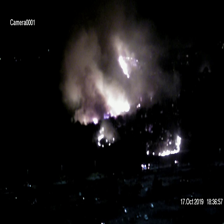

In [6]:
Image.open(data['path'][0]).resize((224,224))

In [10]:
label = data['class']

In [7]:
def get_encode_vector(model, dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    latent_vectors = []
    trans = transforms.Compose([
                transforms.Resize(256),                   
                transforms.CenterCrop(224),
                transforms.ToTensor()
                ])
    model.eval()
    for i in range(len(data)):
        path_img = data['path'].iloc[i]
        label = data['class'].iloc[i]
        img = Image.open(path_img).convert("RGB")
        img = trans(img).unsqueeze(0).to(device)
        latent_vector =  en.encode(model,img)
        latent_vectors.append(latent_vector.reshape(1,-1))
    
    return latent_vectors

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Resnet 152


In [7]:
args_dict = {
    "arch": "resnet152",
    "resume": "./caltech256-resnet152.pth",
    "parallel" : 0   
}
args_namespace = argparse.Namespace(**args_dict)

model_resnet152 = builder.BuildAutoEncoder(args_namespace)

In [8]:
resnet152_vector = get_encode_vector(model_resnet152, data)
resnet_vector_concatenated = np.concatenate(resnet152_vector,axis=0)

### Origin way

Text(0, 0.5, 'Cumulative Explained Variance Ratio')

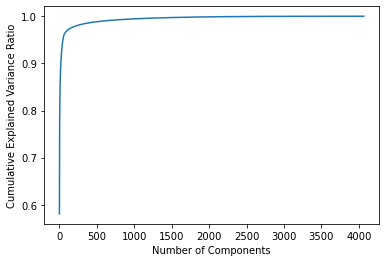

In [99]:
pca = PCA()
pca.fit(resnet_vector_concatenated)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')

In [100]:
pca_resnet152 = PCA(n_components=2000)
pca_resnet152.fit(resnet_vector_concatenated)

test_transform_resnet152 = pca_resnet152.transform(resnet_vector_concatenated)
kmeans_resnet152 = KMeans(n_clusters=5)
kmeans_resnet152.fit(test_transform_resnet152)
y_kmeans_resnet152 = kmeans_resnet152.predict(test_transform_resnet152)

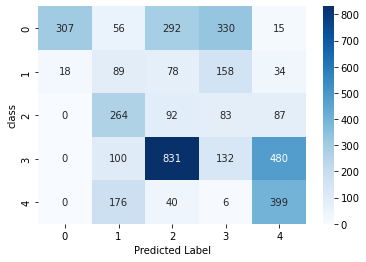

In [101]:
conf_matrix = confusion_matrix(label, y_kmeans_resnet152)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('class')
plt.show()

### Variance based reduction

In [92]:
resnet_vector_concatenated.shape

(4067, 100352)

In [93]:
mean_rvc152 = None
sample_class= data['class'].value_counts()
sample_class = sample_class.sort_index()
s=0
for i in range(len(sample_class)):
    k = sample_class[i]
    if mean_rvc152 is None:
        mean_rvc152 = np.mean(resnet_vector_concatenated[s:s+k, :], axis = 0)
    else:
        mean_rvc152 = np.vstack((mean_rvc152,np.mean(resnet_vector_concatenated[s:s+k, :], axis = 0)))
    s=s+k

In [94]:
mean_rvc152.shape

(5, 100352)

In [95]:
variances = np.var(mean_rvc152, axis=0)

sorted_indices = np.argsort(variances)[::-1]

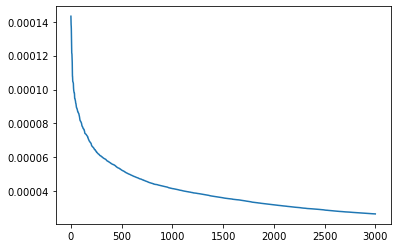

In [96]:
var_list=np.var(mean_rvc152,axis=0)
np.max(var_list)
sorted_var_list = sorted(var_list,reverse=True)

plt.plot(sorted_var_list[:3000])

In [97]:
data_selected = resnet_vector_concatenated[:, sorted_indices[:4000]]
data_selected.shape

(4067, 4000)

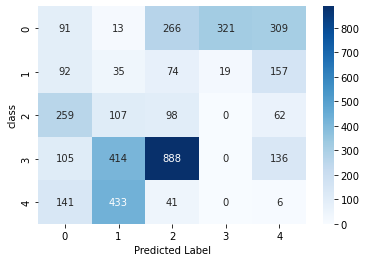

In [98]:
# pca_resnet152 = PCA(n_components=1000)
# pca_resnet152.fit(mean_rvc152)

# test_transform_resnet152 = pca_resnet152.transform(mean_rvc152)
kmeans_resnet152 = KMeans(n_clusters=5)
kmeans_resnet152.fit(data_selected)
y_kmeans_resnet152 = kmeans_resnet152.predict(data_selected)
conf_matrix = confusion_matrix(label, y_kmeans_resnet152)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('class')
plt.show()

## Vgg16

In [12]:
args_dict = {
    "arch": "vgg16",
    "resume": "./imagenet-vgg16.pth",
    "parallel" : 0   
}
args_namespace = argparse.Namespace(**args_dict)

model_vgg = builder.BuildAutoEncoder(args_namespace)

In [13]:
vgg_vector = get_encode_vector(model_vgg, data)
vgg_vector_concatenated = np.concatenate(vgg_vector, axis=0)
vgg_vector_concatenated.shape

(4067, 25088)

### Normal PCA method

Text(0, 0.5, 'Cumulative Explained Variance Ratio')

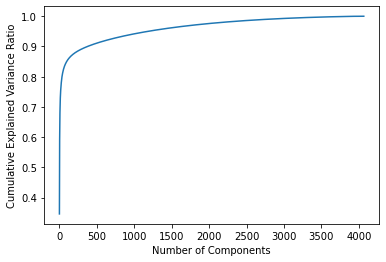

In [29]:
pca = PCA()
pca.fit(vgg_vector_concatenated)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')

In [18]:
pca_vgg = PCA(n_components=3000)
pca_vgg.fit(vgg_vector_concatenated)

test_transform_vgg = pca_vgg.transform(vgg_vector_concatenated)
kmeans_vgg16 = KMeans(n_clusters=5)
kmeans_vgg16.fit(test_transform_vgg)
y_kmeans_vgg = kmeans_vgg16.predict(test_transform_vgg)

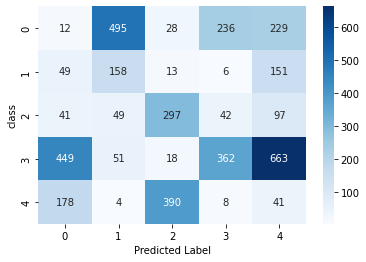

In [ ]:
conf_matrix = confusion_matrix(label, y_kmeans_vgg)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('class')
plt.show()

### Variance based reduction

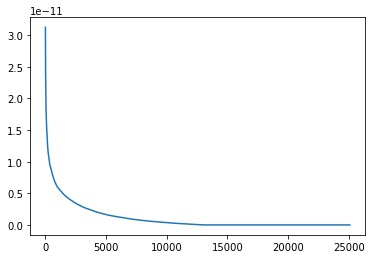

In [88]:
mean_vgg16 = None
sample_class= data['class'].value_counts()
sample_class = sample_class.sort_index()
s=0
for i in range(len(sample_class)):
    k = sample_class[i]
    if mean_vgg16 is None:
        mean_vgg16 = np.mean(vgg_vector_concatenated[s:s+k, :], axis = 0)
    else:
        mean_vgg16 = np.vstack((mean_vgg16,np.mean(vgg_vector_concatenated[s:s+k, :], axis = 0)))
    s=s+k

variances = np.var(mean_vgg16, axis=0)
sorted_indices = np.argsort(variances)[::-1]

var_list=np.var(mean_vgg16,axis=0)

sorted_var_list = sorted(var_list,reverse=True)

plt.plot(sorted_var_list)

In [89]:
data_selected = vgg_vector_concatenated[:, sorted_indices[:4000]]
data_selected.shape

(4067, 4000)

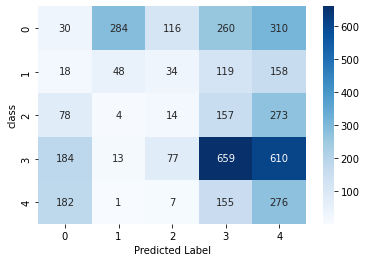

In [91]:
kmean_vgg16 = KMeans(n_clusters=5)
kmean_vgg16.fit(data_selected)
y_kmeans_vgg16 = kmean_vgg16.predict(data_selected)
conf_matrix = confusion_matrix(label, y_kmeans_vgg16)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('class')
plt.show()

In [102]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1000, min_samples=100)
pred = dbscan.fit_predict(test_transform_vgg)
pred



array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [103]:
np.unique(pred)

array([0], dtype=int64)

In [68]:
unique_labels, counts = np.unique(dbscan.labels_, return_counts=True)
for label, count in zip(unique_labels, counts):
    if label == -1:
        print(f"Noise points: {count}")
    else:
        print(f"Cluster {label}: {count} points")


Cluster 0: 4067 points
